# Setting up

**Upload** images folder from [Drive](https://drive.google.com/drive/folders/1k71bUZh5biqd04zzTQpm97fDBEDxrxRa)

Using sample iris image (still waiting for account activation to download `CASIA_iris`)

In [2]:
%pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
%pip install supervision
%pip install jupyter_bbox_widget

ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/segment-anything.git'"

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for jupyter_bbox_widget from https://files.pythonhosted.org/packages/96/0f/9e1f50a37d0776dede4d260584369bf5e1f956670a796e50c9b565f32de7/jupyter_bbox_widget-0.5.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for ipywidgets>=7.0.0 from https://files.pythonhosted.org/packages/70/1a/7edeedb1c089d63ccd8bd5c0612334774e90cf9337de9fe6c82d90081791/ipywidgets-8.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.10 from https://files.pythonhosted.org/packages/99/bc/82a8c3985209ca7c0a61b383c80e015fd92e74f8ba0ec1af98f9d6ca8dce/widgetsnbextension-4.0.10-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.10 from https://files.pythonhosted.org/packages/24/da/db1cb0387a7e4086780aff137987ee924e953d7f91b2a870f994b9b1eeb8/jupyterlab_widgets-3.0.10-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/367.8 kB ? eta -:--:--
   ---------------------------


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
HOME_PATH = os.getcwd()

In [3]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = os.path.join(HOME_PATH, "weights", "sam_vit_h_4b8939.pth")
DEVICE = "cpu"  # "cpu"/"cuda"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# Segmentation

In [3]:
mask_predictor = SamPredictor(sam)


(480, 640, 3)

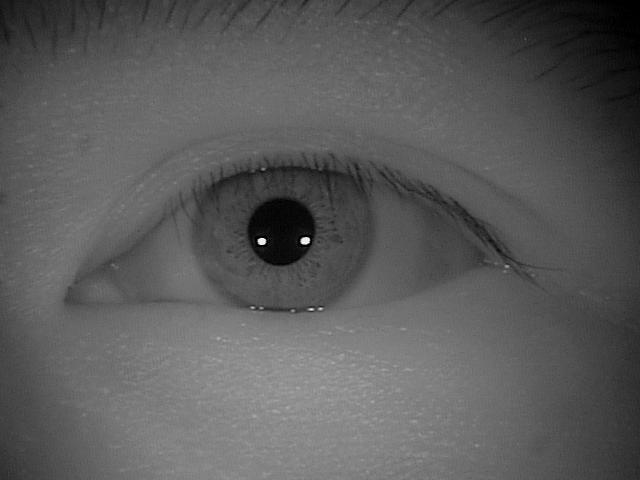

In [33]:
import os
import base64
import cv2

#image = os.path.join(HOME_PATH, "images", "iris.jpg")
image = os.path.join(HOME_PATH, "images", "CASIA-Iris-Thousand","000","R","S5000R00.jpg")
img = cv2.imread(image)


def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded


print(encode_image(image))
print(img.shape)

## Box Prompt

In [34]:
from jupyter_bbox_widget import BBoxWidget


widget = BBoxWidget()
widget.image = encode_image(image)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [35]:
import numpy as np

def widgetToBox(box):
  return np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
  ])

iris_box = widgetToBox(widget.bboxes[0])
print(iris_box)

[193 149 374 326]


SAM model does not support multiple box prompting. It supports point prompt (including points/excluding points) [Prompt Example](https://www.kaggle.com/code/danpresil1/segment-anything-model-sam-prompt-examples/notebook)

---



In [43]:
mask_predictor.set_image(img)

In [37]:
masks, scores, logits = mask_predictor.predict(
    box=iris_box, #iris
    multimask_output=True
)

In [21]:
import supervision as sv

def showAnnotator(masks,scores,show_mask=[0,1,2],ann_mode="bbox"):
  if ann_mode == "bbox": annotator = sv.BoundingBoxAnnotator(color=sv.Color.RED,color_lookup=sv.ColorLookup.INDEX)
  elif ann_mode == "circle": annotator = sv.CircleAnnotator(color=sv.Color.RED,color_lookup=sv.ColorLookup.INDEX)

  mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=masks),
      mask=masks
  )

  mask_img = []
  titles = []
  for i in show_mask:
    mask_img.append(annotator.annotate(scene=img.copy(), detections=detections[i]))
    mask_img.append(mask_annotator.annotate(scene=img.copy(), detections=detections[i]))
    titles.append(f'Border of Mask {i}')
    titles.append(f'Mask {i} Score={scores[i]}')
  
  sv.plot_images_grid(
    images=mask_img,
    grid_size=(len(show_mask), 2),
    titles=titles
  )

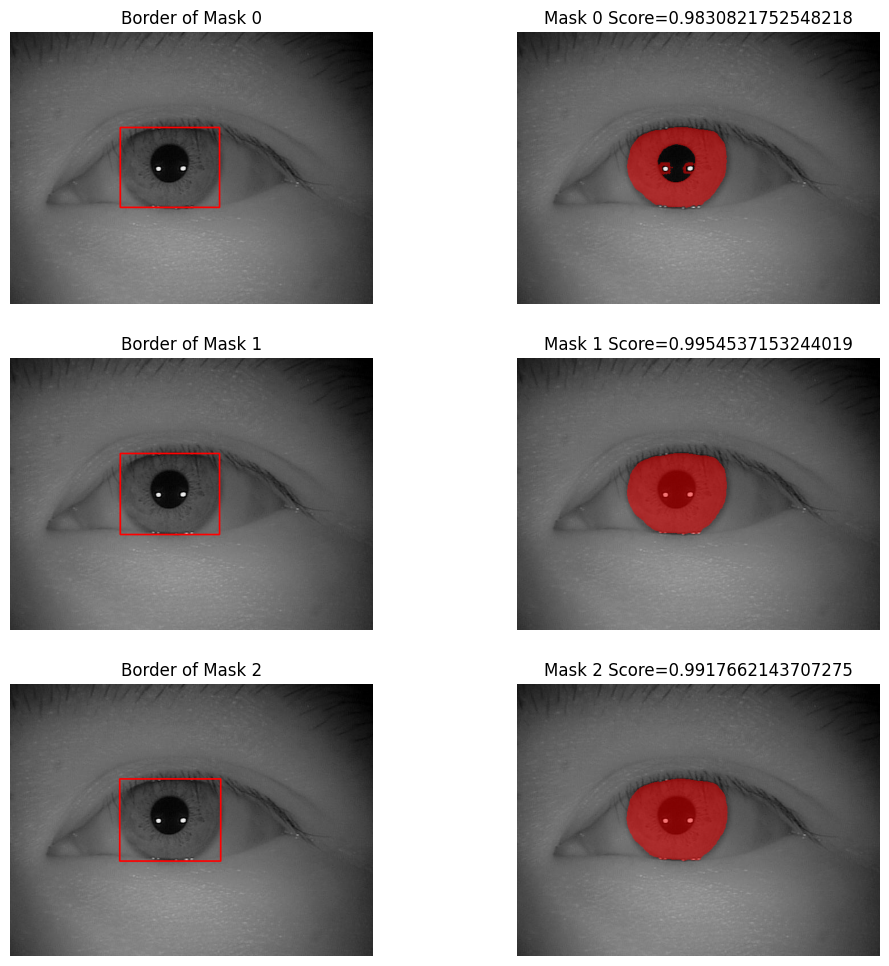

In [38]:
showAnnotator(masks,scores,[0,1,2])

## Point Prompt

In [23]:
import matplotlib.pyplot as plt
import numpy as np


def pointPlot(includes:list, excludes:list, img):

  plt.imshow(img)
  for point in includes:
    plt.plot(point[0],point[1],'go')
  for point in excludes:
    plt.plot(point[0],point[1],'ro')
  plt.axis('on')
  plt.show()

  point_coords = np.array(includes+excludes)
  point_labels = np.array([1]*len(includes)+[0]*len(excludes))
  return point_coords, point_labels


def maskPredict(point_coords, point_labels, mask_predictor):
  masks, scores, logits = mask_predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    multimask_output=True
  )

  mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=masks),
      mask=masks
  )
  mask1 = mask_annotator.annotate(scene=img.copy(), detections=detections[0])
  mask2 = mask_annotator.annotate(scene=img.copy(), detections=detections[1])
  mask3 = mask_annotator.annotate(scene=img.copy(), detections=detections[2])
  #print(detections)

  sv.plot_images_grid(
      images=[mask1, mask2, mask3],
      grid_size=(1, 3),
      titles=[
              f'Mask 1, Score={scores[0]}',
              f'Mask 2, Score={scores[1]}',
              f'Mask 3, Score={scores[2]}'
            ]
  )
  #return masks, scores, logits

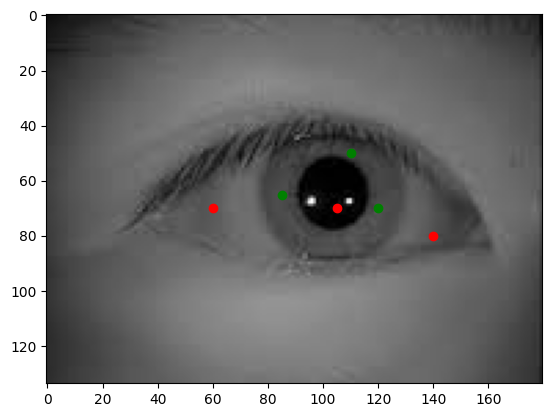

In [24]:
includes = [[85,65],[110,50],[120,70]]
excludes = [[105,70],[60,70],[140,80]]
point_coords, point_labels = pointPlot(includes, excludes, img)
# print(point_coords,'\n')
# print(point_labels)

In [ ]:
mask_predictor.set_image(img)

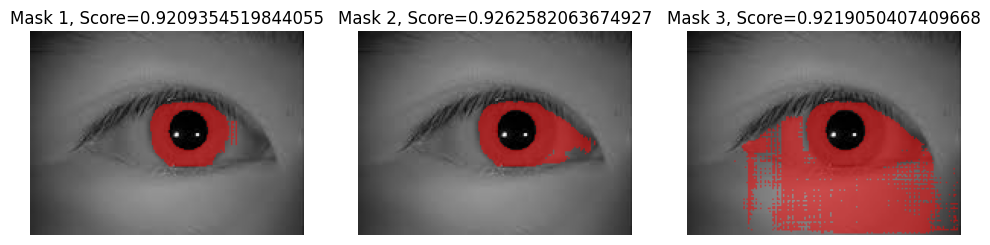

In [25]:
maskPredict(point_coords, point_labels,mask_predictor)

Box Prompt seems to have a better result than point prompt